# Professional XGBoost Workflow with GPU-acceleration For Beginners

In this workflow, we will load a real-life yellow cab trips dataset from the city of New York.
We will clean it, analyze it and feed it into an XGBoost model.

## Manage GPU Memory
Set the `initial_pool_size` to half of the VRAM of your GPU.
<br>
For example: if you have RTX 4080 with 16GB of VRAM - then set `initial_pool_size="8GB"`

In [1]:
import rmm
 
rmm.reinitialize(pool_allocator=True, initial_pool_size="8GB")

## Load Dataset

In [2]:
%load_ext cudf.pandas

import pandas as pd

data = pd.read_csv("Distilled_2023_Yellow_Taxi_Trip_Data.csv")
data.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4999995,1,05/01/2023 03:01:24 PM,05/01/2023 03:08:56 PM,1,1.10,1,N,107,137,2,9.3,2.5,0.5,0.00,0.0,1.0,13.30,2.5,0.0
4999996,2,12/16/2023 06:04:34 PM,12/16/2023 06:12:02 PM,1,0.72,1,N,68,186,1,8.6,0.0,0.5,1.00,0.0,1.0,13.60,2.5,0.0
4999997,2,08/28/2023 04:14:44 PM,08/28/2023 04:24:36 PM,1,1.85,1,N,43,142,1,12.1,2.5,0.5,4.65,0.0,1.0,23.25,2.5,0.0
4999998,1,06/29/2023 07:14:52 PM,06/29/2023 07:27:39 PM,1,2.60,1,N,246,143,1,14.9,5.0,0.5,5.30,0.0,1.0,26.70,2.5,0.0
4999999,1,12/18/2023 05:27:45 PM,12/18/2023 05:45:34 PM,1,2.50,1,N,170,236,1,15.6,5.0,0.5,4.40,0.0,1.0,26.50,2.5,0.0


## Handle Missing Values

### Find Missing Values
Let's first find out how many missing values we have in different columns.

In [3]:
data.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          170476
trip_distance                 0
RatecodeID               170476
store_and_fwd_flag       170476
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     170476
airport_fee              170476
dtype: int64

### Replace Missing Values

Missing values of different kinds should be handled separately.
For example, if an airport charge is missing, it suggests that there was no airport charge, and therefore the charge is 0. Alternatively, if the passenger count is missing, it is more likely that the driver forgot to enter the number of passengers rather than that no passengers were involved in the trip. And so we handle each column differently.

In [4]:
# fill with 0
data["airport_fee"] = data["airport_fee"].fillna(0)
data["congestion_surcharge"] = data["congestion_surcharge"].fillna(0)
# fill with other numbers
data["passenger_count"] = data["passenger_count"].fillna(data["passenger_count"].mean())
data["RatecodeID"] = data["RatecodeID"].fillna(99)
# drop non-meaningful column
data = data.drop(columns=["store_and_fwd_flag"])

## Verify Values Were Replaced
Let's make sure the missing values are gone, before we move on with training.

In [5]:
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## Machine Learning

### Train and Test Split

In [6]:
def train_test_split(data):
    # shuffle data
    data = data.sample(frac=1, random_state=432).reset_index(drop=True)
    
    # extract features and targets
    targets = data["tip_amount"]
    features = data.drop(columns=["tip_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime"])
    
    # split into test and train features and targets
    x_train, x_test = features.iloc[:-1000000], features.iloc[-1000000:]
    y_train, y_test = targets.iloc[:-1000000], targets.iloc[-1000000:]
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = train_test_split(data)

### Train Model

In [7]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 5-fold data splitter for K-Fold Validation
kf = KFold(n_splits=5, shuffle=True, random_state=432)

def training_run(x_train, y_train, x_test, kf):
    """
    Train Model on Dataset and Return It
    """
    ############## VALIDATION ##############
    valid_mses = [] # collect mean squared error during validation

    # split training data into 5-Folds
    for train_idx, valid_idx in kf.split(np.arange(len(x_train))):
        # reserve 1/5 of the training data at a time
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # create validation model
        model = XGBRegressor(device="cuda", enable_categorical=True)
        # train model on the current fold
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        # test validation model
        valid_preds = model.predict(X_val)
        # record mse
        valid_mses.append(mean_squared_error(y_val, valid_preds))

    ############## TRAINING ###############
    # create new model
    final_model = XGBRegressor(device="cuda", enable_categorical=True)
    # train it on the full training data
    final_model.fit(x_train, y_train)
    # test model and get mse
    final_preds = final_model.predict(x_test)
    final_mse = mean_squared_error(y_test, final_preds)
    
    return final_model, final_preds, final_mse, valid_mses

# train first model
model1, predictions1, mse1, valid_mses1 = training_run(x_train, y_train, x_test, kf)

### Evaluate Model

In [8]:
# === metrics: model 1 ===
valid_mse1 = float(np.mean(valid_mses1))
valid_mse_std1  = float(np.std(valid_mses1))
test_mse1 = float(mse1)

print(
    "MODEL 1",
    "\nvalid mse", valid_mse1,
    "\ntest mse",    test_mse1,
    "\nvalid mse std", valid_mse_std1
     )

MODEL 1 
valid mse 0.9507273285367897 
test mse 1.125281266868761 
valid mse std 0.05066188085146984


## Data Optimization

### Find Anomalies
Summarise the dataset and find outstanding values

In [9]:
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.937378
PULocationID,1.00,265.00,165.211125
RatecodeID,1.00,99.00,4.957792
VendorID,1.00,6.00,1.738975
airport_fee,-1.75,1.75,0.135050
congestion_surcharge,-2.50,2.50,2.188012
extra,-7.50,67.33,1.556050
fare_amount,-768.10,2100.00,19.500016
improvement_surcharge,-1.00,1.00,0.979552
mta_tax,-0.50,4.00,0.485634


### Handle Anomalies
- There is no such thing as a negative amount or charge. It must be a refund.
- A trip with a distance of 0 is not a trip.
- There is no chance that there was a trip in the distance of 345,729 miles.

In [10]:
data = data[data["trip_distance"] > 0.5]
data = data[data["trip_distance"] < 100]
data = data[~data.select_dtypes("number").lt(0).any(axis=1)]

### Verify Anomaly Handling

In [11]:
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.569507
PULocationID,1.00,265.00,164.950451
RatecodeID,1.00,99.00,4.288704
VendorID,1.00,6.00,1.747534
airport_fee,0.00,1.75,0.144952
congestion_surcharge,0.00,2.50,2.258322
extra,0.00,67.33,1.603440
fare_amount,0.00,633.00,20.328010
improvement_surcharge,0.00,1.00,0.999500
mta_tax,0.00,4.00,0.496888


## Handle Total Amount Anomaly

The base fare of yellow cabs is 3.00 USD before the meter even starts, and then it's about 70 cents per mile.
So if we set our minimum trip distance to be 0.5 miles - then the minimum total_amount should be 3.70 USD.

In [12]:
data = data[data["total_amount"] > 3.7]

In [13]:
data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.00,265.00,163.570355
PULocationID,1.00,265.00,164.952203
RatecodeID,1.00,99.00,4.286890
VendorID,1.00,6.00,1.747576
airport_fee,0.00,1.75,0.144956
congestion_surcharge,0.00,2.50,2.258500
extra,0.00,67.33,1.603564
fare_amount,0.00,633.00,20.329613
improvement_surcharge,0.00,1.00,0.999531
mta_tax,0.00,4.00,0.496920


## Second Training Run

In [14]:
# new train and test split
x_train, x_test, y_train, y_test = train_test_split(data)

# train Model 2 with CV
model2, predictions2, mse2, valid_mses2 = training_run(x_train, y_train, x_test, kf)

# evaluate
# === metrics: model 2 ===
valid_mse2 = float(np.mean(valid_mses2))
valid_mse_std2 = float(np.std(valid_mses2))
test_mse2 = float(mse2)

print(
    "MODEL 2",
    "\nvalid mse", valid_mse2,
    "\ntest mse",    test_mse2,
    "\nvalid mse std", valid_mse_std2
     )

MODEL 2 
valid mse 0.8925997839705063 
test mse 0.8211419402822228 
valid mse std 0.0856521519551422


## Handle Dates

### Extract Date Data

In [15]:
date_format = "%m/%d/%Y %I:%M:%S %p"

data["tpep_pickup_datetime"]  = pd.to_datetime(
    data["tpep_pickup_datetime"], format=date_format
)
data["tpep_dropoff_datetime"] = pd.to_datetime(
        data["tpep_dropoff_datetime"], format=date_format
)

data["pickup_month"] = data["tpep_pickup_datetime"].dt.month
data["dropoff_month"] = data["tpep_dropoff_datetime"].dt.month

data["pickup_dow"]   = data["tpep_pickup_datetime"].dt.dayofweek  
data["dropoff_dow"]   = data["tpep_dropoff_datetime"].dt.dayofweek

data["pickup_ampm"]  = data["tpep_pickup_datetime"].dt.strftime("%p").astype("category")
data["dropoff_ampm"] = data["tpep_dropoff_datetime"].dt.strftime("%p").astype("category")

diff = data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]
data["trip_duration_min"] = (diff.dt.total_seconds() / 60).astype("float32")

data.select_dtypes(include="number").agg(["min", "max", "mean"]).T

,min,max,mean
DOLocationID,1.000000,265.000000,163.570355
PULocationID,1.000000,265.000000,164.952203
RatecodeID,1.000000,99.000000,4.286890
VendorID,1.000000,6.000000,1.747576
airport_fee,0.000000,1.750000,0.144956
congestion_surcharge,0.000000,2.500000,2.258500
dropoff_dow,0.000000,6.000000,3.006637
dropoff_month,1.000000,12.000000,6.507684
extra,0.000000,67.330000,1.603564
fare_amount,0.000000,633.000000,20.329613


### Handle Trip Duration Anomalies

In [16]:
data = data[data["trip_duration_min"] > 1]
data = data[data["trip_duration_min"] < 120]

data["trip_duration_min"].agg(["min", "max", "mean"]).T

min       1.016667
max     119.983330
mean     17.012554
Name: trip_duration_min, dtype: float32

## Third Train Run

In [17]:
# new train and test split
x_train, x_test, y_train, y_test = train_test_split(data)

# train Model 2 with CV
model3, predictions3, mse3, valid_mses3 = training_run(x_train, y_train, x_test, kf)

# evaluate
# === metrics: model 2 ===
valid_mse3 = float(np.mean(valid_mses3))
valid_mse_std3 = float(np.std(valid_mses3))
test_mse3 = float(mse3)

print(
    "MODEL 3",
    "\nvalid mse", valid_mse3,
    "\ntest mse",    test_mse3,
    "\nvalid mse std", valid_mse_std3
     )

MODEL 3 
valid mse 0.8096194289752677 
test mse 0.9730265597334978 
valid mse std 0.036915440877315325


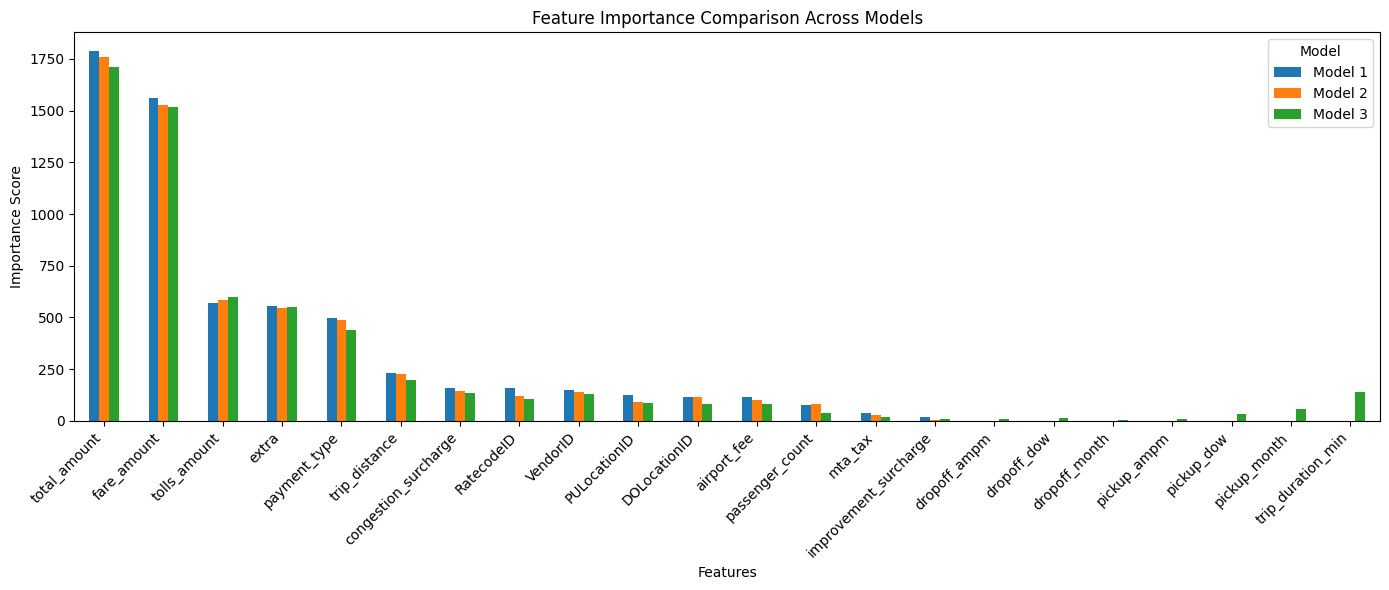

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

models = [model1, model2, model3]
names = ['Model 1', 'Model 2', 'Model 3']

def get_importance_df(model, name):
    booster = model.get_booster()
    imp = booster.get_score(importance_type='weight')
    df = pd.DataFrame({
        'Feature': list(imp.keys()),
        name: list(imp.values())
    })
    return df

# Combine importances from all models
dfs = [get_importance_df(m, n) for m, n in zip(models, names)]
merged = dfs[0]
for df in dfs[1:]:
    merged = merged.merge(df, on='Feature', how='outer').fillna(0)

# Sort by one model or by mean importance
merged = merged.set_index('Feature')
merged = merged.sort_values(by=names[0], ascending=False).head(30)

# Plot side-by-side bars
ax = merged.plot(
    kind='bar',
    figsize=(14, 6)
)

plt.title('Feature Importance Comparison Across Models')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning with Validation

### Revise Training Run Function 
Allow Variation in Learning Rate and Estimators

In [19]:
def hyper_training_run(x_train, y_train, x_test, kf, learning_rate=None, n_estimators=None):
    """
    5-fold validation on x_train/y_train, then refit on full train.
    Returns: final_model, final_preds, final_mse, valid_mses
    """
    valid_mses = []

    # split train data into 5 folds for validation
    for train_idx, valid_idx in kf.split(np.arange(len(x_train))):
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # initialize model with varying hyperparameters
        model = XGBRegressor(
            device="cuda",
            enable_categorical=True,
            learning_rate=learning_rate, # hyperparameter 1
            n_estimators=n_estimators # hyperparameter 2
        )
        
        # perform validation
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        # get validation predictions and mse
        valid_preds = model.predict(X_val)
        valid_mses.append(mean_squared_error(y_val, valid_preds))

    # create final model
    final_model = XGBRegressor(
        device="cuda",
        enable_categorical=True,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    # train on full training data
    final_model.fit(x_train, y_train, verbose=False)
    # get test predictions and mse
    final_preds = final_model.predict(x_test)
    final_mse = mean_squared_error(y_test, final_preds)

    return final_model, final_preds, final_mse, valid_mses

### Perform Hyper Parameter Tuning
Using different learning rates and n_estimators

In [21]:
import pandas as pd
import numpy as np

# choose hyperparameters to experiment with
learning_rates = [0.1, 0.05]
n_estimators = [200, 500, 1000]

model_info = []
# loop over hyperparameter #1
for lr in learning_rates:
    # loop over hyperparameter #2
    for ne in n_estimators:
        # perform training run
        _, _, test_mse, valid_mses = hyper_training_run(
            x_train, y_train, x_test, kf,
            learning_rate=lr,
            n_estimators=ne
        )
        # record training results
        model_info.append({
            "learning_rate": lr,
            "n_estimators": ne,
            "valid mse": float(np.mean(valid_mses)),
            "valid mse std": float(np.std(valid_mses)),
            "test mse": float(test_mse)
        })
        print("*********************\n", model_info[-1])

results_df = pd.DataFrame(model_info).sort_values(["valid mse", "valid mse std"], ascending=[True, True])
display(results_df)

*********************
 {'learning_rate': 0.1, 'n_estimators': 200, 'valid mse': 0.8605583845697172, 'valid mse std': 0.041597500517340624, 'test mse': 1.0320709031778215}
*********************
 {'learning_rate': 0.1, 'n_estimators': 500, 'valid mse': 0.7579287757887893, 'valid mse std': 0.0427710746388618, 'test mse': 0.9317902801403484}
*********************
 {'learning_rate': 0.1, 'n_estimators': 1000, 'valid mse': 0.7612316121789202, 'valid mse std': 0.03988669789611936, 'test mse': 0.9331812837886942}
*********************
 {'learning_rate': 0.05, 'n_estimators': 200, 'valid mse': 1.1167414503434103, 'valid mse std': 0.04473284791195392, 'test mse': 1.2838180782342938}
*********************
 {'learning_rate': 0.05, 'n_estimators': 500, 'valid mse': 0.8154471494023012, 'valid mse std': 0.040102473584590646, 'test mse': 0.9988949517767044}
*********************
 {'learning_rate': 0.05, 'n_estimators': 1000, 'valid mse': 0.7515170273078375, 'valid mse std': 0.04012616366363305, 'test 

,learning_rate,n_estimators,valid mse,valid mse std,test mse
5,0.05,1000,0.751517,0.040126,0.939471
1,0.10,500,0.757929,0.042771,0.931790
2,0.10,1000,0.761232,0.039887,0.933181
4,0.05,500,0.815447,0.040102,0.998895
0,0.10,200,0.860558,0.041598,1.032071
3,0.05,200,1.116741,0.044733,1.283818


### Plot Hyperparameter Tuning Results

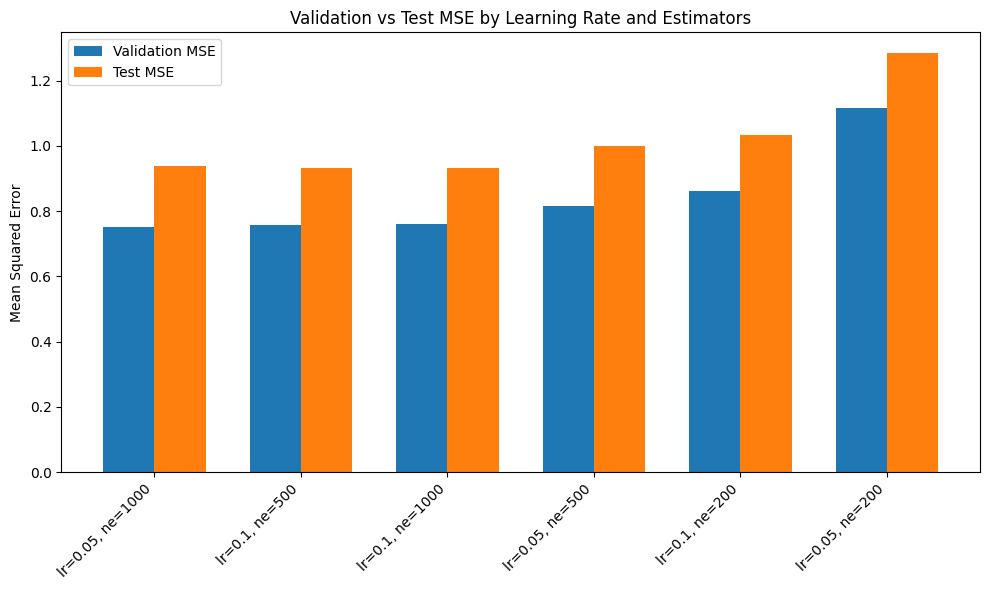

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df["valid mse"], width, label="Validation MSE")
plt.bar(x + width/2, results_df["test mse"], width, label="Test MSE")

plt.xticks(x, [
    f"lr={lr}, ne={ne}"
    for lr, ne in zip(results_df["learning_rate"], results_df["n_estimators"])
], rotation=45, ha="right")

plt.ylabel("Mean Squared Error")
plt.title("Validation vs Test MSE by Learning Rate and Estimators")
plt.legend()
plt.tight_layout()
plt.show()

## Train Best Model on Best Learning Rate and Best Estimators

In [23]:
best_lr = float(results_df.iloc[0]["learning_rate"])
best_ne = int(results_df.iloc[0]["n_estimators"])
print({"best_learning_rate": best_lr, "best_n_estimators": best_ne})

# optional: final fit using the best combo
best_model, best_preds, best_test_mse, best_valid_mses = hyper_training_run(
    x_train, y_train, x_test, kf,
    learning_rate=best_lr,
    n_estimators=best_ne
)

print({
    "valid mse": float(np.mean(best_valid_mses)),
    "valid mse std": float(np.std(best_valid_mses)),
    "test mse": float(best_test_mse)
})

{'best_learning_rate': 0.05, 'best_n_estimators': 1000}
{'valid mse': 0.7515170273078375, 'valid mse std': 0.04012616366363305, 'test mse': 0.9394707376621527}
